# Week 6 Notebook - SVMs and CNNs

If you want to run the svm_gui.py example as we do in class, you will need to remove matplotlib installed with Anaconda (which breaks tkinter support) and reinstall it with pip. Use the following commands:

<code>conda uninstall matplotlib
pip install matplotlib</code>

Then from your command line, you can launch the application with ipython after navigating to the right directory:

<code>ipython svm_gui.py</code>

## Iris SVMs

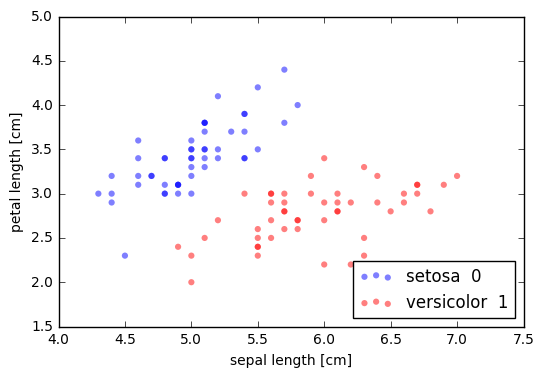

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
X = df.iloc[0:100, [0,1]].values
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.2, random_state=5)

stdscaler = preprocessing.StandardScaler().fit(X_train)
X_scaled  = stdscaler.transform(X)
X_train_scaled = stdscaler.transform(X_train)
X_test_scaled  = stdscaler.transform(X_test)

# plot data
plt.scatter(X[:50, 0], X[:50, 1],alpha=0.5, c='b', edgecolors='none', label='setosa %2s'%(y[0]))
plt.scatter(X[50:100, 0], X[50:100, 1],alpha=0.5, c='r', edgecolors='none', label='versicolor %2s'%(y[50]))
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='lower right')
plt.show()

def plot_decision_2d(clf,X,y,title="Decision Regions"):
    '''
    plot_decision_2d(clf,X,y)
    Plots a 2D decision region.
    '''
    # create a mesh to plot in
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

    h = (x_max-x_min)/1000.0 # step size in the mesh

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)

    # Plot also the training points
    plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5, edgecolors='none')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.grid(alpha=0.2)
    plt.show()

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        13
          1       1.00      1.00      1.00         7

avg / total       1.00      1.00      1.00        20

Hinge loss 0.65


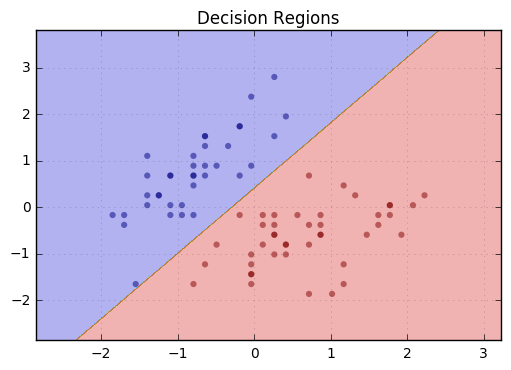

In [2]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import hinge_loss

svc = SVC(kernel='linear', C=1)
svc.fit(X_train_scaled, y_train)
predicted = svc.predict(X_test_scaled)
print classification_report(y_test,predicted)
print "Hinge loss", hinge_loss(y_test,predicted)
plot_decision_2d(svc,X_train_scaled,y_train)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        13
          1       1.00      1.00      1.00         7

avg / total       1.00      1.00      1.00        20

Hinge loss 0.65


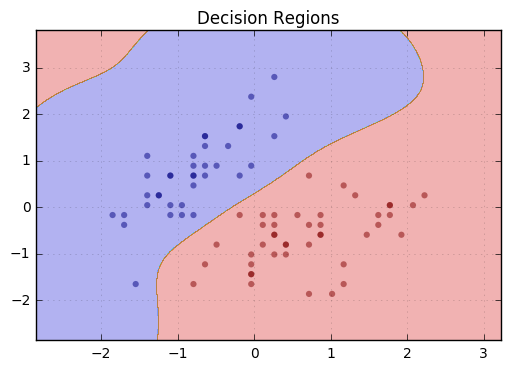

In [3]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import hinge_loss

svc = SVC(kernel='rbf', gamma=1, C=1)
svc.fit(X_train_scaled, y_train)
predicted = svc.predict(X_test_scaled)
print classification_report(y_test,predicted)
print "Hinge loss", hinge_loss(y_test,predicted)
plot_decision_2d(svc,X_train_scaled,y_train)

             precision    recall  f1-score   support

          0       1.00      0.46      0.63        13
          1       0.50      1.00      0.67         7

avg / total       0.82      0.65      0.64        20

Hinge loss 1.0


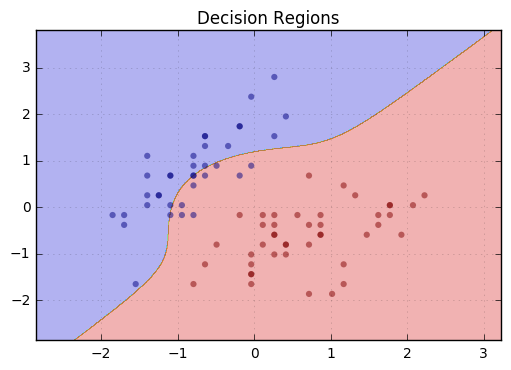

In [4]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import hinge_loss

svc = SVC(kernel='poly', degree=5, C=1)
svc.fit(X_train_scaled, y_train)
predicted = svc.predict(X_test_scaled)
print classification_report(y_test,predicted)
print "Hinge loss", hinge_loss(y_test,predicted)
plot_decision_2d(svc,X_train_scaled,y_train)

## Disaster Tweets Revisitied: Cosine Similarity SVM

In [5]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import re

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

tweets = pd.read_csv('socialmedia-disaster-tweets-DFE.csv')[['text','choose_one']]
tweets.columns = ['tweet','class']
tweets = tweets[(tweets['class'] == 'Relevant') | (tweets['class'] == 'Not Relevant')]
tweets = tweets.reset_index(drop=True)

# Clean tweet text of HTML, etc.
tweets['tweet'] = tweets.tweet.map(preprocessor)

# Reindex randomly
tweets = tweets.reindex(index=np.random.permutation(tweets.index))

# Setup transformer analyzer and subsequent bag-of-words transformer
from nltk.corpus import stopwords
from string import ascii_lowercase as alphabet

import nltk
nltk.download('stopwords')

stop = stopwords.words('english')
stop.extend([unicode(letter) for letter in alphabet])

def split_into_lemmas(tweet):
    tweet = unicode(tweet, 'utf8').lower()
    words = TextBlob(tweet).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words if word not in stop]

# Create bag-of-words transformer to apply to data in next cell
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(tweets.tweet)

# Transform the tweets in dataset to bag-of-words
tweets_bow = bow_transformer.transform(tweets.tweet)
print 'sparse matrix shape:', tweets_bow.shape
print 'number of non-zeros:', tweets_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * tweets_bow.nnz / (tweets_bow.shape[0] * tweets_bow.shape[1]))

# Split resulting tweets_bow vector into traning and testing sets
tweets_bow_train = tweets_bow[:8000]
tweets_bow_test = tweets_bow[8000:]
tweets_class_train = tweets['class'][:8000]
tweets_class_test = tweets['class'][8000:]

print ("Tweets training shape: ", tweets_bow_train.shape)
print ("Tweets testomg shape:  ", tweets_bow_test.shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mlclass/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
sparse matrix shape: (10860, 26085)
number of non-zeros: 117319
sparsity: 0.04%
('Tweets training shape: ', (8000, 26085))
('Tweets testomg shape:  ', (2860, 26085))


In [6]:
from sklearn.naive_bayes import MultinomialNB

tweet_class_clf  = MultinomialNB().fit(tweets_bow_train, tweets_class_train)

predictions = tweet_class_clf.predict(tweets_bow_test)

print "Multinomial Naive Bayes Results: \n"

print classification_report(tweets_class_test, predictions)

def predict_tweet(new_tweet): 
    new_sample = bow_transformer.transform([new_tweet])
    print new_tweet
    print "MNB Prediction: ", np.around(tweet_class_clf.predict_proba(new_sample), decimals=5),"\n"

predict_tweet('Cat stuck in a tree.')
predict_tweet('FIRE ABLAZE')

Multinomial Naive Bayes Results: 

             precision    recall  f1-score   support

Not Relevant       0.82      0.85      0.83      1638
   Relevant       0.78      0.75      0.76      1222

avg / total       0.80      0.80      0.80      2860

Cat stuck in a tree.
MNB Prediction:  [[ 0.61247  0.38753]] 

FIRE ABLAZE
MNB Prediction:  [[ 0.39919  0.60081]] 



In [7]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics.pairwise import cosine_similarity

tweet_class_svc = SVC(kernel=cosine_similarity, C=0.85).fit(tweets_bow_train, tweets_class_train)

predictions = tweet_class_svc.predict(tweets_bow_test)

print "SVC Results: \n"

print classification_report(tweets_class_test, predictions)

def predict_tweet_svc(new_tweet): 
    new_sample = bow_transformer.transform([new_tweet])
    print new_tweet
    print "SVC Prediction: ", tweet_class_svc.predict(new_sample)[0], "\n"

predict_tweet_svc('Cat stuck in a tree.')
predict_tweet_svc('FIRE ABLAZE')

SVC Results: 

             precision    recall  f1-score   support

Not Relevant       0.80      0.89      0.84      1638
   Relevant       0.82      0.70      0.76      1222

avg / total       0.81      0.81      0.81      2860

Cat stuck in a tree.
SVC Prediction:  Not Relevant 

FIRE ABLAZE
SVC Prediction:  Relevant 



## NotMNIST SVC

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import cross_validation
from scipy.io import loadmat

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import hinge_loss
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import Perceptron


data = loadmat('notMNIST_small.mat')
X_temp = (data['images']/255)-0.5

#for i in range(X_temp.shape[2]):
    
X = np.empty(shape=[X_temp.shape[2]] + [784], dtype='float32')
for i in range(X_temp.shape[2]):
    X[i,:] = X_temp[:,:,i].flatten()

y = data['labels']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.2, random_state=50)
print X_train.shape
print X_test.shape

(14979, 784)
(3745, 784)


In [9]:
%%time

svc = LinearSVC(C=1)
svc.fit(X_train, y_train)
predicted = svc.predict(X_test)

print "Linear SVC Results\nConfusion Matrix: "
print confusion_matrix(y_test,predicted)
print "\n Classifcation Report"
print classification_report(y_test,predicted)

Linear SVC Results
Confusion Matrix: 
[[308   8   4   5   2   2   4  10   4  12]
 [  2 316   4   5   8  10   4   6  11   5]
 [  3   4 324   1   8   1  11   1   6   2]
 [  6   9   2 306   2   4   5   5   8  11]
 [  1   8  16   4 292   4  10   5  11   6]
 [  4   1   4   1   6 336   3   4  11   5]
 [  4   7  12   3   9   3 323   3  10   9]
 [ 16  11   5   6   3  10   7 331   8   5]
 [  8   2   2   5  10   9   9   7 341  20]
 [  5   5   1   8   4   8   4   4   8 319]]

 Classifcation Report
             precision    recall  f1-score   support

        0.0       0.86      0.86      0.86       359
        1.0       0.85      0.85      0.85       371
        2.0       0.87      0.90      0.88       361
        3.0       0.89      0.85      0.87       358
        4.0       0.85      0.82      0.83       357
        5.0       0.87      0.90      0.88       375
        6.0       0.85      0.84      0.85       383
        7.0       0.88      0.82      0.85       402
        8.0       0.82      0.

In [10]:
%%time

ppn = Perceptron()
ppn.fit(X_train, y_train)
predicted = ppn.predict(X_test)

print "Perceptron Results\nConfusion Matrix: "
print confusion_matrix(y_test,predicted)
print "\n Classifcation Report"
print classification_report(y_test,predicted)

Perceptron Results
Confusion Matrix: 
[[306   6   8   3   4   1   3  10   2  16]
 [  5 315   8  16   8   4   2   3   7   3]
 [  0   3 336   1   7   0   8   2   2   2]
 [  5   4   4 316   3   0   1   2   6  17]
 [  1   1  37   0 279   2   5   5  21   6]
 [  2   0  16   1   6 317   1  10  12  10]
 [  2   5  27   8   4   1 315   5   5  11]
 [  5   8  14   6  14   5   9 325   5  11]
 [  9   3  20   5   8   2   3  11 331  21]
 [  3   1   7   4   2   0   2   3   4 340]]

 Classifcation Report
             precision    recall  f1-score   support

        0.0       0.91      0.85      0.88       359
        1.0       0.91      0.85      0.88       371
        2.0       0.70      0.93      0.80       361
        3.0       0.88      0.88      0.88       358
        4.0       0.83      0.78      0.81       357
        5.0       0.95      0.85      0.90       375
        6.0       0.90      0.82      0.86       383
        7.0       0.86      0.81      0.84       402
        8.0       0.84      0.

In [11]:
%%time

svc = SVC(kernel='poly', degree=2, C=1)
svc.fit(X_train, y_train)
predicted = svc.predict(X_test)

print "SVC w/Polynomial Kernel Results\nConfusion Matrix: "
print confusion_matrix(y_test,predicted)
print "\n Classifcation Report"
print classification_report(y_test,predicted)

SVC w/Polynomial Kernel Results
Confusion Matrix: 
[[311  13   1   0   2   0   4  10  14   4]
 [  2 335   0   2   6   2   6   3  15   0]
 [  0   7 313   1  15   2   8   0  15   0]
 [  6  25   0 305   3   1   3   2  11   2]
 [  3  13   5   1 312   2   6   1  12   2]
 [  2   5   0   0   6 343   0   2  14   3]
 [  3  20   4   2   6   3 326   4  12   3]
 [ 14  19   0   0   6   5   2 337  16   3]
 [  9   6   0   6   7   4   4   6 356  15]
 [  5   8   0   2   0   2   3   0  22 324]]

 Classifcation Report
             precision    recall  f1-score   support

        0.0       0.88      0.87      0.87       359
        1.0       0.74      0.90      0.82       371
        2.0       0.97      0.87      0.92       361
        3.0       0.96      0.85      0.90       358
        4.0       0.86      0.87      0.87       357
        5.0       0.94      0.91      0.93       375
        6.0       0.90      0.85      0.88       383
        7.0       0.92      0.84      0.88       402
        8.0      

## Convolutional Neural Network

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing,cross_validation
from scipy.io import loadmat
data = loadmat('notMNIST_small.mat')
X_temp = data['images']/255

testing_size = 3745
training_size = X_temp.shape[2] - testing_size

X = np.empty(shape=[X_temp.shape[2]] + [1,28,28], dtype='float32')
for i in range(X_temp.shape[2]):
    X[i,0,:,:] = X_temp[:,:,i]

y = data['labels']

X_train, X_test, y_train_orig, y_test_orig = cross_validation.train_test_split(
    X, y, test_size=0.2, random_state=50)

y_train_orig = y_train_orig.reshape(-1,1)
y_test_orig = y_test_orig.reshape(-1,1)

In [21]:
enc = preprocessing.OneHotEncoder(sparse=False).fit(y_train_orig)
y_train = enc.transform(y_train_orig)
y_test = enc.transform(y_test_orig)

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.regularizers import l2, l1
from keras.optimizers import SGD

model = Sequential()
model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1, 28, 28), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 32, 24, 24)    832         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 32, 12, 12)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 32, 12, 12)    0           maxpooling2d_3[0][0]             
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 4608)          0           dropout_3[0][0]                  
___________________________________________________________________________________________

In [24]:
model = model.fit(X_train, y_train,  batch_size = 256,
          nb_epoch = 20, verbose=2, validation_data=(X_test,y_test))

Train on 14979 samples, validate on 3745 samples
Epoch 1/20
11s - loss: 0.6608 - acc: 0.8248 - val_loss: 0.3689 - val_acc: 0.8964
Epoch 2/20
9s - loss: 0.3106 - acc: 0.9139 - val_loss: 0.2879 - val_acc: 0.9250
Epoch 3/20
9s - loss: 0.2469 - acc: 0.9301 - val_loss: 0.2600 - val_acc: 0.9311
Epoch 4/20
9s - loss: 0.2087 - acc: 0.9406 - val_loss: 0.2343 - val_acc: 0.9364
Epoch 5/20
9s - loss: 0.1827 - acc: 0.9458 - val_loss: 0.2430 - val_acc: 0.9359
Epoch 6/20
9s - loss: 0.1617 - acc: 0.9522 - val_loss: 0.2264 - val_acc: 0.9375
Epoch 7/20
9s - loss: 0.1442 - acc: 0.9573 - val_loss: 0.2274 - val_acc: 0.9370
Epoch 8/20
9s - loss: 0.1278 - acc: 0.9633 - val_loss: 0.2171 - val_acc: 0.9397
Epoch 9/20
9s - loss: 0.1144 - acc: 0.9666 - val_loss: 0.2196 - val_acc: 0.9391
Epoch 10/20
9s - loss: 0.0956 - acc: 0.9727 - val_loss: 0.2262 - val_acc: 0.9375
Epoch 11/20
9s - loss: 0.0936 - acc: 0.9716 - val_loss: 0.2336 - val_acc: 0.9394
Epoch 12/20
10s - loss: 0.0823 - acc: 0.9754 - val_loss: 0.2245 - va

In [25]:
predicted = model.model.predict_classes(X_test)

3744/3745 [============================>.] - ETA: 0s

In [26]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

print "Convolution Network Results\nConfusion Matrix: "
print confusion_matrix(y_test_orig,predicted)
print "\n Classifcation Report"
print classification_report(y_test_orig,predicted)

Convolution Network Results
Confusion Matrix: 
[[324   8   3   1   0   1   0  15   5   2]
 [  0 360   0   6   1   0   0   2   2   0]
 [  0   2 344   1   5   0   5   1   3   0]
 [  1   4   1 345   0   0   1   1   1   4]
 [  1   7   7   1 333   1   1   0   4   2]
 [  0   2   0   0   1 361   1   1   6   3]
 [  1  12  10   4   4   1 343   0   5   3]
 [  1   5   0   5   1   0   1 381   5   3]
 [  1   2   4  10   6   1   0   3 377   9]
 [  0   1   0   7   0   1   0   1  12 344]]

 Classifcation Report
             precision    recall  f1-score   support

        0.0       0.98      0.90      0.94       359
        1.0       0.89      0.97      0.93       371
        2.0       0.93      0.95      0.94       361
        3.0       0.91      0.96      0.93       358
        4.0       0.95      0.93      0.94       357
        5.0       0.99      0.96      0.97       375
        6.0       0.97      0.90      0.93       383
        7.0       0.94      0.95      0.94       402
        8.0       0.9